# STAT 301 Final Project: Group 22

### Group members: Siluni Jayarathne, Bhumika Kalra, Jeff Lu, Sofiia Prylypka

## Table of contents:
* [Introduction](#Introduction)
* [Method and Results](#Method-and-Results)
* [Discussion](#Discussion)
* [References](#References)

## Introduction
- Thanks to the rapid digitalization of the world, online shopping has begun reaching a wider audience than ever. As a result, there has been a large push for retail companies to curate personalized shopping experiences for customers. However, the factors that are associated with customer's purchase decision are complex and not yet fully understood (Zhou et al., 2017), making it unclear which aspects of a website should be personalized to maximize revenue.
- Because of this, we would like to determine the association between a site visitor's purchasing decision (response), and predictors related to the site visitor's browsing behaviour (e.g. time spent on various types of pages, web page bounce rate) and time of site visit (e.g. whether the user visited on a special day or weekend). Our primary goal is inference, since we are trying to understand which predictors are relevant to purchasing decisions, rather than trying to predict a new visitor's purchasing decision.

## Method and Results

### Data

In [2]:
# Load required libraries
library(tidyverse)
library(dplyr)
library(broom)
library(car)
library(MASS)
library(tidymodels)
library(patchwork)
library(modelr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──

✔ dials        1.2.1     ✔ rsample      1.2.1
✔ infer        1.0.7     ✔ tune         1.2.1
✔ modeldata

In [3]:
# Do not change
set.seed(1234)

# Download and load dataset from the Web
zipped <- tempfile()
download.file("https://archive.ics.uci.edu/static/public/468/online+shoppers+purchasing+intention+dataset.zip", zipped)
unzipped <- unz(zipped, "online_shoppers_intention.csv")
shopping <- read.csv(unzipped) |> 
    filter(Region != 1) # As required for our group's data

shopping <- shopping %>%
  mutate(Month = factor(Month))
# Split into selection and inference sets to avoid the post-inference problem
shopping_split <- initial_split(shopping, prop = 0.5, strata = Revenue)
shopping_selection <- training(shopping_split)
# Do not touch this set until the final step
shopping_inference <- testing(shopping_split)

head(shopping_selection, 3)

Administrative Administrative_Duration Informational Informational_Duration
1 0              0                       0             0                     
2 0              0                       0             0                     
3 0              0                       0             0                     
  ProductRelated ProductRelated_Duration BounceRates ExitRates  PageValues
1 1                0                     0.2         0.20000000 0         
2 3              395                     0.0         0.06666667 0         
3 1                0                     0.2         0.20000000 0         
  SpecialDay Month OperatingSystems Browser Region TrafficType
1 0.4        Feb   2                4       3      3          
2 0.0        Feb   1                1       3      3          
3 0.0        Feb   1                1       4      3          
  VisitorType       Weekend Revenue
1 Returning_Visitor FALSE   FALSE  
2 Returning_Visitor FALSE   FALSE  
3 Returning_Visitor FALSE   FALSE

##### Dataset summary
- For this project, our group will be working with the [Online Shoppers Purchasing Intention Dataset](https://archive.ics.uci.edu/dataset/468/online+shoppers+purchasing+intention+dataset).
- This dataset was collected from an observational study and includes data about browser sessions of users visiting an online shopping website.
- The dataset contains 18 variables (described below) for 12,330 observations, with no missing values; however, we will only use observations where the Region is not 1, as specified in our group's instructions.
<table><thead>
  <tr>
    <th>Variable Name</th>
    <th>Type</th>
    <th>Description</th>
    <th>Data collection method</th>
  </tr></thead>
<tbody>
  <tr>
    <td>Administrative</td>
    <td>Integer</td>
    <td>Number of administrative pages visited</td>
    <td>Derived from URL information</td>
  </tr>
  <tr>
    <td>Administrative_Duration</td>
    <td>Continuous</td>
    <td>Total time spent on administrative pages (s)</td>
    <td>Derived from URL information</td>
  </tr>
  <tr>
    <td>Informational</td>
    <td>Integer</td>
    <td>Number of informational pages visited</td>
    <td>Derived from URL information</td>
  </tr>
  <tr>
    <td>Informational_Duration</td>
    <td>Continuous</td>
    <td>Total time spent on informational pages (s)</td>
    <td>Derived from URL information</td>
  </tr>
  <tr>
    <td>ProductRelated</td>
    <td>Integer</td>
    <td>Number of product-related pages visited</td>
    <td>Derived from URL information</td>
  </tr>
  <tr>
    <td>ProductRelated_Duration</td>
    <td>Continuous</td>
    <td>Total time spent on product-related pages (s)</td>
    <td>Derived from URL information</td>
  </tr>
  <tr>
    <td>BounceRates</td>
    <td>Continuous</td>
    <td>Average bounce rate (leaving a page without analytics server requests) of pages visited</td>
    <td>Google Analytics</td>
  </tr>
  <tr>
    <td>ExitRates</td>
    <td>Continuous</td>
    <td>Average exit rate of pages visited</td>
    <td>Google Analytics</td>
  </tr>
  <tr>
    <td>PageValues</td>
    <td>Continuous</td>
    <td>Average value for a web page visited</td>
    <td>Google Analytics</td>
  </tr>
  <tr>
    <td>SpecialDay</td>
    <td>Continuous</td>
    <td>Value between 0 and 1 indicating closeness of site visit to special day</td>
    <td>Calculated based on dynamics of e-commerce</td>
  </tr>
  <tr>
    <td>Month</td>
    <td>Categorical</td>
    <td>Month of site visit</td>
    <td>NA</td>
  </tr>
  <tr>
    <td>OperatingSystems</td>
    <td>Categorical (encoded as Integer)</td>
    <td>Operating system used during site visit</td>
    <td>NA</td>
  </tr>
  <tr>
    <td>Browser</td>
    <td>Categorical (encoded as Integer)</td>
    <td>Browser used during site visit</td>
    <td>NA</td>
  </tr>
  <tr>
    <td>Region</td>
    <td>Categorical (encoded as Integer)</td>
    <td>Geographic region of session</td>
    <td>NA</td>
  </tr>
  <tr>
    <td>TrafficType</td>
    <td>Categorical (encoded as Integer)</td>
    <td>Type of traffic that brought visitor to site</td>
    <td>NA</td>
  </tr>
  <tr>
    <td>VisitorType</td>
    <td>Categorical</td>
    <td>"Returning Visitor," "New Visitor," or "Other"</td>
    <td>NA</td>
  </tr>
  <tr>
    <td>Weekend</td>
    <td>Binary</td>
    <td>Whether the site visit was on a weekend</td>
    <td>NA</td>
  </tr>
  <tr>
    <td>Revenue</td>
    <td>Binary</td>
    <td>Whether the session ended in a transaction</td>
    <td>NA</td>
  </tr>
</tbody></table>

### Exploratory Data Analysis

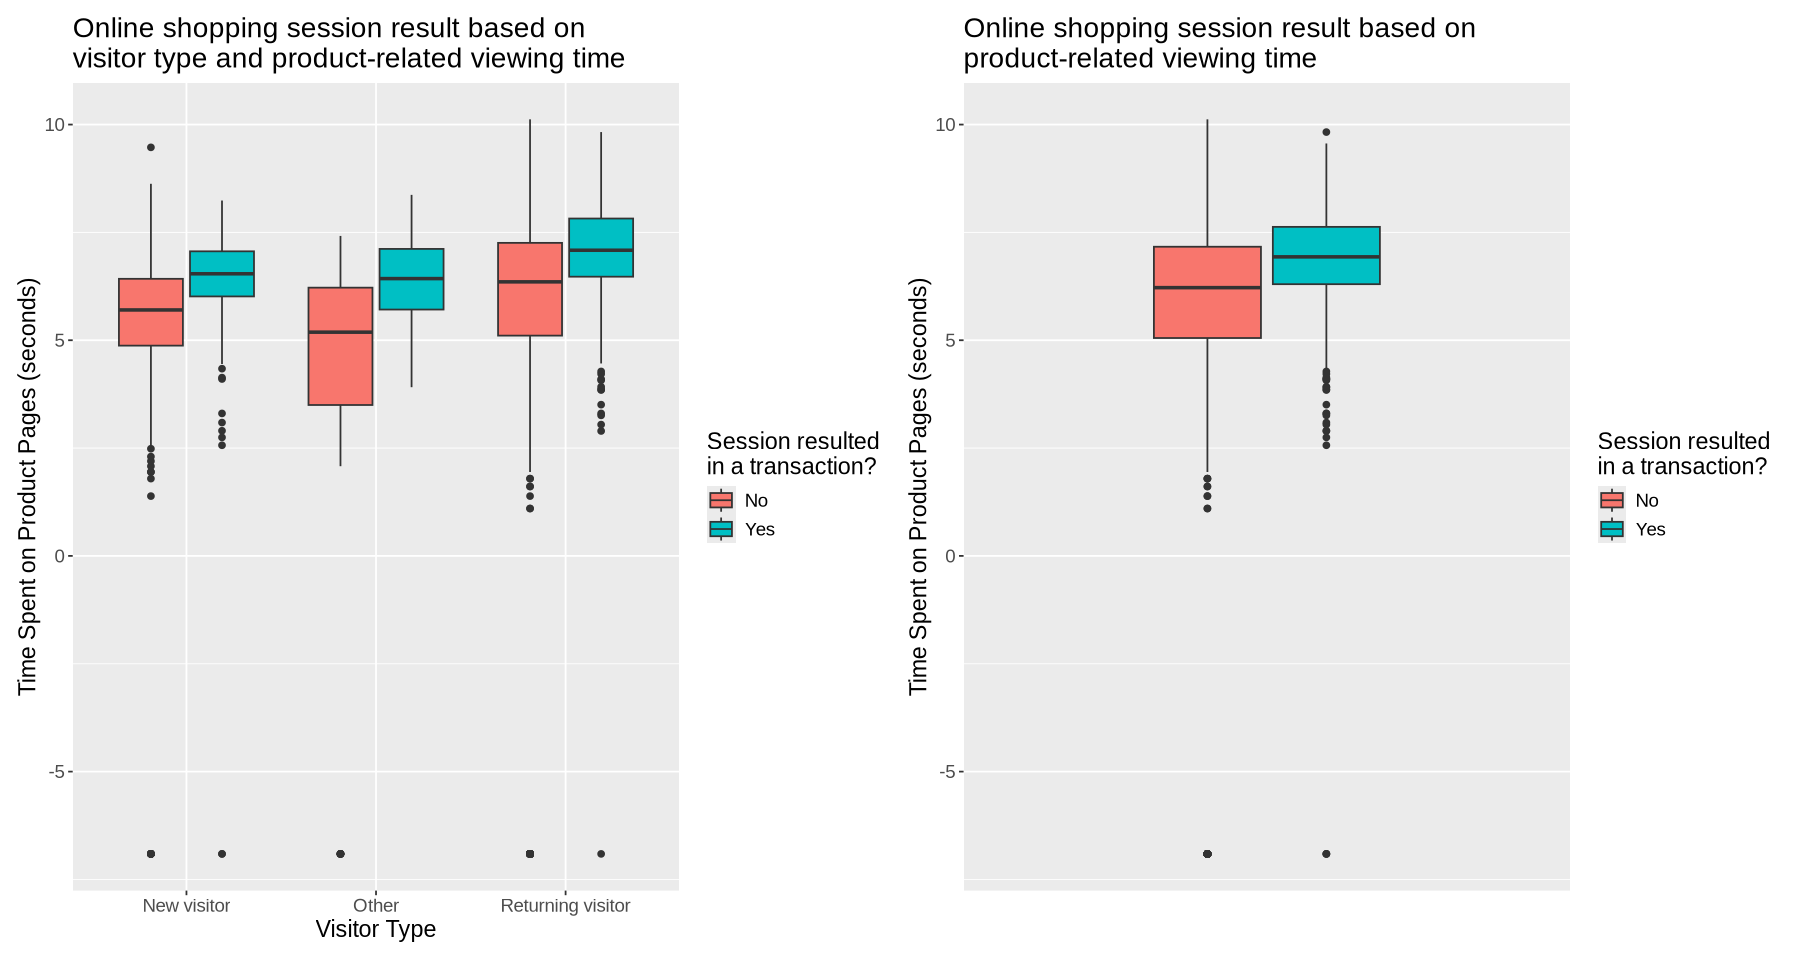

In [4]:
options(repr.plot.height = 8, repr.plot.width = 15)

# Visualization 1
vis_by_visitor_type <- ggplot(shopping_selection) +
    # Use log scale for y due to large variance; add small constant to smooth zero values
    geom_boxplot(aes(y = log(ProductRelated_Duration + 0.001), x = VisitorType, fill = Revenue)) +
    labs(y = "Time Spent on Product Pages (seconds)",
         fill = "Session resulted\nin a transaction?", x = "Visitor Type") +
    scale_fill_discrete(labels = c("No", "Yes")) +
    scale_x_discrete(labels = c("New visitor", "Other", "Returning visitor")) +
    theme(text = element_text(size = 14)) +
    ggtitle("Online shopping session result based on\nvisitor type and product-related viewing time")

vis_aggregated <- ggplot(shopping_selection) +
    # Use log scale for y due to large variance; add small constant to smooth zero values
    geom_boxplot(aes(y = log(ProductRelated_Duration + 0.001), fill = Revenue)) +
    labs(y = "Time Spent on Product Pages (seconds)",
         fill = "Session resulted\nin a transaction?") +
    scale_fill_discrete(labels = c("No", "Yes")) +
    scale_x_discrete(labels = c()) +
    theme(text = element_text(size = 14)) +
    ggtitle("Online shopping session result based on\nproduct-related viewing time")
vis_by_visitor_type + vis_aggregated


A) PLOT RELEVANCE

This box plot examines how ProductRelated_Duration differs between purchasing and non-purchasing sessions across visitor types (New, Other, Returning), helping us identify key behavioral differences that influence purchase decisions. The breakdown by visitor type shows whether browsing patterns change based on customer familiarity with the site.

B) INTERPRETATION
- Sessions resulting in purchases show noticeably higher median product page viewing times across all visitor types, with purchasers spending roughly 30-50% more time than non-purchasers.
- Returning visitors who purchase spend the most time browsing products (median ~7-7.5 seconds), even more than new visitors (~6.5 seconds), suggesting they use their site familiarity to evaluate products more carefully rather than rushing through purchases.
- Purchasing sessions show tighter interquartile ranges, indicating more consistent, focused behavior, while non-purchasing sessions display wider variability ranging from quick exits to extensive browsing without conversion. The right panel confirms this pattern is robust across the entire dataset, with minimal overlap between purchasing and non-purchasing boxes.


C) INSIGHTS

ProductRelated_Duration appears to be a strong predictor with a clear "engagement threshold" around 6-8 seconds where sessions become much more likely to convert. Returning visitors are particularly valuable, spending the most time and converting at higher rates, emphasizing the importance of customer retention strategies.

**Potential Problems:**
1. Both groups have significant outliers where sessions spent 10+ seconds on product pages. These could be legitimate researchers or people who left browsers open, but they could adversly effect our model coefficients and should be investigated or capped.
2. The "Other" visitor category is problematic as it shows the most variability and doesn't fit a clear pattern. This could be a tracking issue, or just a grouping of miscellaneous visitor types, but either way, it adds noise that could weaken our analysis.

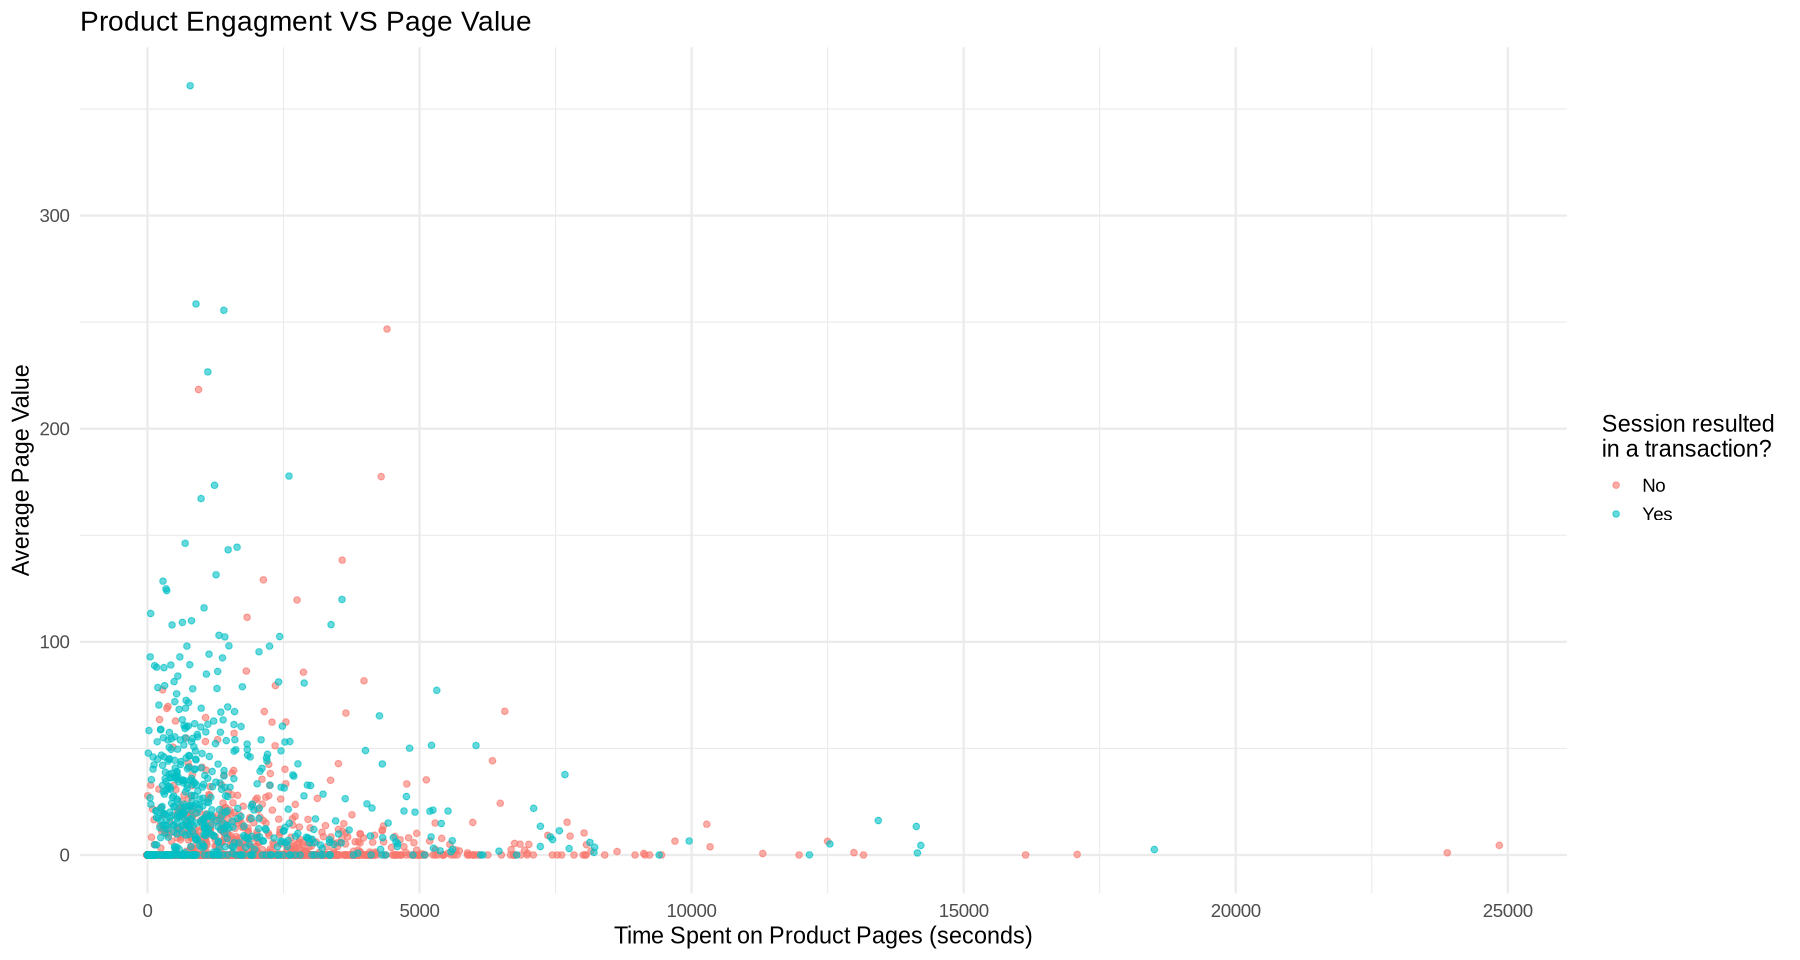

In [5]:
# Visualization 2
online_shopping_plot <-
    ggplot(shopping_selection, aes(x = ProductRelated_Duration, y = PageValues, color = Revenue))+
    geom_point(alpha = 0.6) +
    labs(
        x = "Time Spent on Product Pages (seconds)",
        y = "Average Page Value",
        title = "Product Engagment VS Page Value",
        color = "Session resulted\nin a transaction?") +
    theme_minimal(base_size = 14) +
    scale_color_discrete(labels = c("No", "Yes"))

online_shopping_plot

A) PLOT RELEVANCE

This scatter plot is relevant because it shows how ProductRelated_Duration and PageValues relate to Revenue. Visualizing both predictors simultaneously, helps us
determine which factor more strongly influences conversions and whether browsing time or page value is more influential for predicting purchases.

B) INTERPRETATION
- Contrary to the expected trend that longer browsing increases purchase likelihood, most purchases tend to occur at higher PageValues, even when browsing time is moderate or low.
- Sessions resulting in revenue are more vertically dispersed, showing wider range of page values, while non-purchasing sessions remain at lower page values even when spending a long time browsing (5000-15000+ seconds). This suggests locating relevant content leads to purchases, while long browsing without reaching high-value pages indicates indecision.
- PageValues does a better job separating purchasers from non-purchasers than time alone. Looking vertically at any time range, teal points consistently sit higher than coral points. There are notable outliers: sessions with extremely high durations (20,000+ seconds) and very high page values (200-350+).

C) INSIGHTS

Shoppers are more likely to convert when they reach high-value pages, not when they spend more time browsing. This suggests that page relevance, content quality, and easy navigation play a bigger role than the total time spent. PageValues is likely a strong predictor because it reflects quality engagement, not just time spent.

**Potential Problems:**

1. Extreme outliers (> 20,000 seconds), may reflect bots or idle sessions and could adversly effect our model coefficients and should be investigated or capped.
2. Heavy clustering near the origin reduces variability and may limit the model’s ability to learn meaningful patterns; we may need oversampling or to focus on more engaged sessions.
3. Multicollinearity could be an issue if ProductRelated_Duration and PageValues are correlated enough that including both doesn't add much value. VIFs are needed during model building to see if both should stay in.
4. Finally, the relationship doesn't look linear we see distinct behavioral groups rather than a smooth trend. This suggests we might need to consider how ProductRelated_Duration and PageValues work together (their interaction) when building our model.

### Methods: Plan

- We will first use `stepAIC()` to perform forward variable selection solely on `shopping_selection`. Since our dataset has many categorical variables, `stepAIC` will allow us to select all dummy variables associated with each categorical variable. This will lead to greater interpretability, which is important for inference.
- Using the variables selected, we will fit an additive logistic regression model on `shopping_inference` using `Revenue` as the response. We will use GVIF to check for multicollinearity. If the GVIF for any covariate is greater than 5, we will address it in our analysis.
- Using a logistic regression model is appropriate because the response variable `Revenue` is binary, so it will ensure that the fitted values are bounded between 0 and 1 as they should be. Also, using logistic regression will make the interpretation much more intuitive (e.g. we can say some variable is associated with some increase in the *odds* of a session resulting in a purchase), which is important for inference.

### Code and Results

In [12]:
# Null model
shopping_null <- glm(Revenue ~ 1, family = binomial, data = shopping_selection)
shopping_null_results <- shopping_null %>% tidy()

# Full model with all covariates
shopping_full <- glm(Revenue ~ ., family = binomial, data = shopping_selection)
shopping_full_results <- shopping_full %>% tidy()

# Forward selection on null model
AIC_forward <- stepAIC(shopping_null, direction = "forward", k = log(nrow(shopping_selection)), 
                       scope = list(lower = shopping_null, upper = shopping_full))

# Summary of the forward selection
summary(AIC_forward)

Start:  AIC=3205.43
Revenue ~ 1

                          Df Deviance    AIC
+ PageValues               1   2391.4 2407.8
+ ExitRates                1   2872.0 2888.5
+ BounceRates              1   3009.9 3026.4
+ ProductRelated_Duration  1   3132.5 3149.0
+ ProductRelated           1   3134.6 3151.1
+ Administrative           1   3152.6 3169.0
+ Month                    9   3093.5 3175.8
+ VisitorType              2   3159.8 3184.5
+ SpecialDay               1   3172.2 3188.7
+ Administrative_Duration  1   3177.4 3193.9
+ Informational            1   3179.3 3195.8
<none>                         3197.2 3205.4
+ Informational_Duration   1   3190.2 3206.7
+ Browser                  1   3193.1 3209.5
+ Weekend                  1   3193.7 3210.2
+ OperatingSystems         1   3197.1 3213.5
+ Region                   1   3197.1 3213.6
+ TrafficType              1   3197.2 3213.6

Step:  AIC=2407.85
Revenue ~ PageValues

                          Df Deviance    AIC
+ ExitRates              


Call:
glm(formula = Revenue ~ PageValues + ExitRates + Month + ProductRelated_Duration, 
    family = binomial, data = shopping_selection)

Coefficients:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)             -1.650e+00  2.763e-01  -5.972 2.34e-09 ***
PageValues               7.541e-02  4.120e-03  18.302  < 2e-16 ***
ExitRates               -2.440e+01  3.284e+00  -7.429 1.09e-13 ***
MonthDec                -5.186e-01  3.103e-01  -1.671  0.09466 .  
MonthFeb                -1.731e+00  1.099e+00  -1.575  0.11525    
MonthJul                 2.047e-01  3.729e-01   0.549  0.58309    
MonthJune               -3.453e-01  5.298e-01  -0.652  0.51461    
MonthMar                -7.812e-01  3.185e-01  -2.453  0.01418 *  
MonthMay                -5.093e-01  2.874e-01  -1.772  0.07642 .  
MonthNov                 5.143e-01  2.789e-01   1.844  0.06515 .  
MonthOct                -2.121e-01  3.640e-01  -0.583  0.56016    
MonthSep                -2.858e-01  3.655

To identify a parsimonious model, we performed forward stepwise selection using AIC. At the first step, `PageValues` decreased the AIC from 3205.4 to 2407.8, indicating that this predictor provides the largest improvement in model fit among all single-variable additions. Adding `ExitRates` further reduced the AIC to 2298.0. Including `Month` as a categorical predictor lowered the AIC again to 2284.9. Finally, adding `ProductRelated_Duration` further improved the model to an AIC of 2282.9. No additional variables reduced AIC meaningfully, so we will use `PageValues`, `ExitRates`, `Month`, and `ProductRelated_Duration`  to fit a logistic regression model on the inference set.

In [15]:
# Fit logistic regression model on inference set using selected variables
shopping_inference_model <-
    glm(Revenue ~ PageValues + ExitRates + Month + ProductRelated_Duration, family = binomial, data = shopping_inference) 
vif(shopping_inference_model)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


GVIF     Df GVIF^(1/(2*Df))
PageValues              1.060832 1  1.029967       
ExitRates               1.064984 1  1.031980       
Month                   1.066577 9  1.003587       
ProductRelated_Duration 1.060248 1  1.029684

These values are far below the common threshold of GVIF > 5, indicating no problematic multicollinearity in the selected model. Therefore, all predictors can be safely retained without impact on the stability of the model or validity of confidence intervals/hypothesis tests.

In [14]:
shopping_inference_model %>%
    tidy(exponentiate = TRUE, conf.int = TRUE, conf.level = 0.95) %>%
    mutate_if(is.numeric, round, 4) %>% 
    suppressWarnings()

term                    estimate std.error statistic p.value conf.low
1  (Intercept)             0.1306   0.3027    -6.7243   0.0000  0.0703  
2  PageValues              1.0985   0.0049    19.3304   0.0000  1.0883  
3  ExitRates               0.0000   2.5285    -5.4796   0.0000  0.0000  
4  MonthDec                0.5212   0.3306    -1.9710   0.0487  0.2763  
5  MonthFeb                0.2197   1.0619    -1.4273   0.1535  0.0118  
6  MonthJul                0.7171   0.4160    -0.7992   0.4242  0.3130  
7  MonthJune               0.5738   0.4776    -1.1631   0.2448  0.2174  
8  MonthMar                0.7072   0.3252    -1.0654   0.2867  0.3797  
9  MonthMay                0.5732   0.3072    -1.8115   0.0701  0.3199  
10 MonthNov                1.6044   0.2977     1.5879   0.1123  0.9150  
11 MonthOct                1.1564   0.3567     0.4073   0.6838  0.5799  
12 MonthSep                0.9843   0.3967    -0.0399   0.9682  0.4512  
13 ProductRelated_Duration 1.0001   0.0000     3.7905   0.0002  1.0001  
   conf.high
1  0.2310   
2  1.1092   
3  0.0001   
4  1.0141   
5  1.1772   
6  1.6134   
7  1.4322   
8  1.3642   
9  1.0709   
10 2.9504   
11 2.3578   
12 2.1500   
13 1.0002

- At a 5% significance level, we see that the coefficients for the continuous variables `ProductRelated_Duration`, `ExitRates` and `PageValues` are statistically significant, so we can say that if we keep all other variables in the model constant, an increase in `ProductRelated_Duration` or `PageValues` is associated with a multiplicative increase in the odds of a session resulting in a purchase (since their estimated coefficients are greater than 1), while an increase in `ExitRates` is associated with a multiplicative decrease in the odds of a session resulting in a purchase (since its estimated coefficient is less than 1).
- The coefficient for the dummy variable MonthDec is also statistically significant, and the estimated coefficient is less than 1, so we can say that if we keep all other variables in the model constant, sessions made in December are less likely to result in a purchase than those in August.

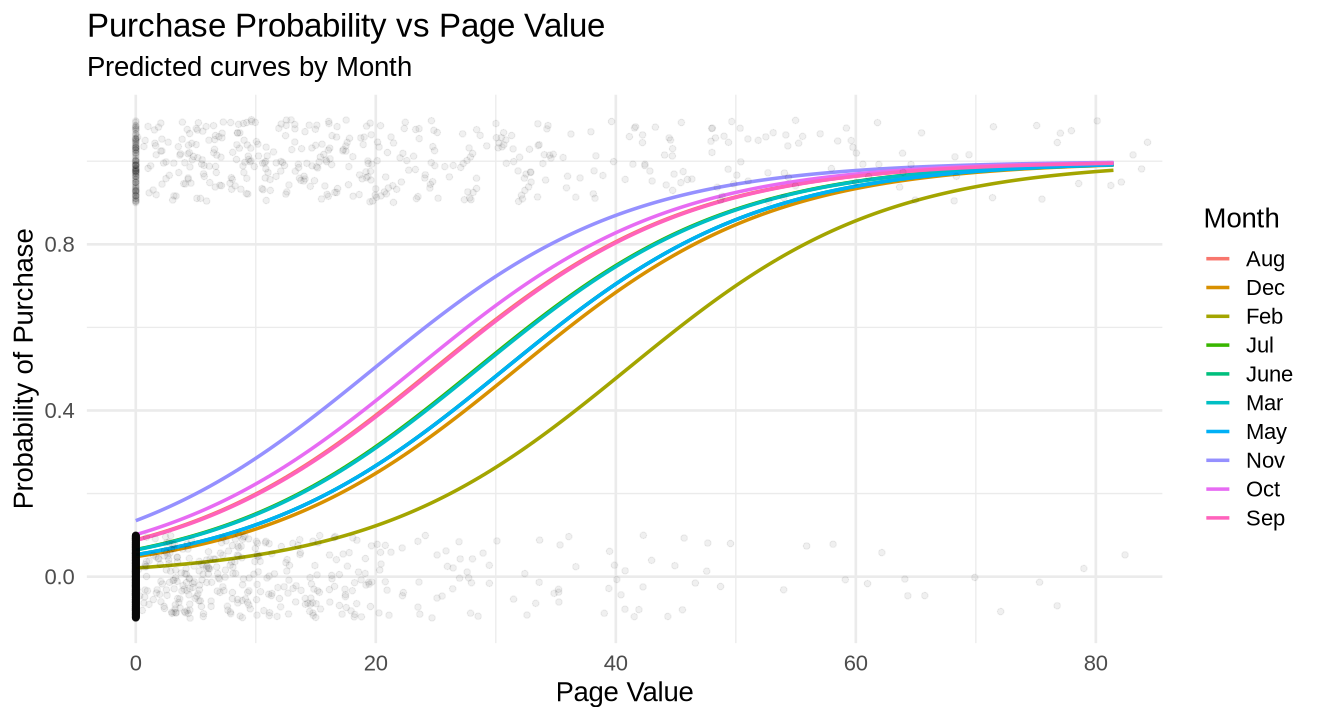

In [21]:
# Determine an upper limit for PageValues to avoid extreme outliers in the plot
x_max <- quantile(shopping_inference$PageValues, 0.99, na.rm = TRUE)

# Create a grid of values for predictions across PageValues and categorical variables
data_for_plotting <- 
  tibble(
    PageValues = seq(0, x_max, length.out = 400)
  ) %>%
  crossing(
    Month = levels(shopping_inference$Month),
    ExitRates = median(shopping_inference$ExitRates, na.rm = TRUE),
      ProductRelated_Duration = median(shopping_inference$ProductRelated_Duration, na.rm = TRUE)
  ) %>%                                
  add_predictions(shopping_inference_model, var = "pred", type = "response")     

# Set plot dimensions
options(repr.plot.width = 11, repr.plot.height = 6)

# Generate visualization 
log_regr_plot <- 
  shopping_inference %>%
  # Predicted purchase probability vs PageValues
  ggplot() +
  geom_line(
    data = data_for_plotting,
    aes(x = PageValues, y = pred, color = Month),
    linewidth = 1
  ) +
  geom_jitter(
    data = shopping_inference,
    aes(x = PageValues, y = as.numeric(Revenue)),
    alpha = 0.06, width = 0, height = 0.1
  ) +
  coord_cartesian(xlim = c(0, x_max)) +
  labs(
    title = "Purchase Probability vs Page Value",
    subtitle = "Predicted curves by Month",
    x = "Page Value",
    y = "Probability of Purchase",
    color = "Month"
  ) +
  theme_minimal(base_size = 16.5)

log_regr_plot

- Across all months, purchase probability increases steadily as PageValues increase, which visually confirms the strong positive effect of PageValues in the model.
- Curves for different months are vertically shifted, which reflects seasonal variation in purchase behaviour (e.g., higher probabilities in Oct/Nov and lower in Feb).
- The shape of the curve is logistic, consistent with the model form: rapid increase between PageValues ~20–50, then flattening as the probability approaches 1.
- The jittered points show noise typical of observational data.

## Discussion



- Our findings reveal both intuitive and surprising factors that contribute to a site visitor's purchasing decision. According to our results, high page values and product viewing times and low exit rates seem to be the most important factors, indicating that online retailers should focus on directing visitors to high-value pages and keeping their attention with visually-pleasing interfaces and easy-to-use controls. Surprisingly, the time of visit seems to be less relevant, with the exception of fewer purchases in December, so it may not be as worthwhile to invest in making seasonal changes to a website.
- Our model could be improved by exploring potential interactions between variables; for example, new visitors might be more willing to experiment with buying from new retailers on holidays, leading to a greater increase in purchasing probability compared to a returning visitor.
- Future studies should either aim to explore factors of purchasing decisions that were not covered by this one (product types and prices, visitor's age and previous purchases, etc.), or conduct an experiment to establish clear causal effects.

## References
Sakar, C. & Kastro, Y. (2018). Online Shoppers Purchasing Intention Dataset [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5F88Q

Sakar, C. O., Polat, S. O., Katircioglu, M., & Kastro, Y. (2018). Real-time prediction of online shoppers’ purchasing intention using Multilayer Perceptron and LSTM recurrent neural networks. *Neural Computing and Applications*, 31(10), 6893–6908. https://doi.org/10.1007/s00521-018-3523-0 

Zhou, L., Dai, L., & Zhang, D. (2007). Online shopping acceptance model — A critical survey of consumer factors in online shopping. *Journal of Electronic Commerce Research*, 8(1).

Link to download dataset: https://archive.ics.uci.edu/static/public/468/online+shoppers+purchasing+intention+dataset.zip